# Interpret test statistics of the GPS tracking model

<code>Code</code>: from session 10.2 by Prof. Carl Scheffler
Below we load the results from fitting a Stan model for the GPS tracking data you saw in the previous session.

Your task is to run the code for generating each test statistic and interpret the results.

 * Does each test statistic indicate that there is a statistically significant discrepancy between our model and our data?
 * If there is a significant discrepancy, what should we do about it to improve our model?

Below we load the `data` and `samples` variables. The data set is the same as you saw in the previous session when we did inference in the GPS tracking model using the sum–product algorithm. The samples were generated by running PyStan on the GPS tracking model. You don't need the Stan model for this activity, but if you are interested in the code, you can [find it here](https://course-resources.minerva.kgi.edu/uploaded_files/mke/00085235-3234/gps-model-stan.py).

In [2]:
import pystan
import pickle

data = {
    'T': 60,
    'mu_x0': 0,
    'sigma_x0': 0.00001,
    'mu_v0': 0,
    'sigma_v0': 13,
    'sigma_x': 1,
    'sigma_v': 1.5,
    'sigma_y': 5,
    'y': [-2.318,  7.296,  5.348, 13.681, 32.533, 25.683, 29.849, 43.268, 62.418, 50.883, 64.500,
          71.580, 63.061, 63.896, 79.208, 61.933, 71.173, 64.820, 50.937, 62.536, 53.729, 45.770,
          42.614, 40.192, 42.358, 31.646, 40.787, 38.133, 34.436, 39.122, 40.889, 36.780, 44.742,
          52.225, 52.734, 67.731, 64.323, 77.476, 73.068, 68.277, 72.424, 80.257, 88.506, 79.651,
          76.694, 76.188, 74.318, 68.890, 54.337, 44.303, 34.900, 24.175, 24.203, 13.167, 16.537,
          11.134, 16.753, 17.231, 8.097, 19.645, 8.728]}

stan_code = '''
data {
    int<lower=1> T;
    real mu_x0;
    real<lower=0> sigma_x0;
    real mu_v0;
    real<lower=0> sigma_v0;
    real<lower=0> sigma_x;
    real<lower=0> sigma_y;
    real<lower=0> sigma_v;
    real y[T+1];
}

parameters {
    real x[T+1];
    real v[T+1];
}

model {
    x[1] ~ normal(mu_x0, sigma_x0);
    v[1] ~ normal(mu_v0, sigma_v0);
    for(t in 1:T) {
        x[t+1] ~ normal(x[t] + v[t], sigma_x);
        v[t+1] ~ normal(v[t], sigma_v);
    }
    y ~ normal(x, sigma_y);
}

generated quantities {
    real y_pred[T+1];
    for(t in 1:(T+1)) {
        y_pred[t] = normal_rng(x[t], sigma_y);
    }
}
'''

stan_model = pystan.StanModel(model_code=stan_code)
results = stan_model.sampling(data=data)
print(results)

samples = results.extract()
with open('model_checking.pickle', 'wb') as fp:
    pickle.dump(data, fp)
    pickle.dump(samples, fp)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b872e01f93f9c2496f853dd57f4d1099 NOW.


Inference for Stan model: anon_model_b872e01f93f9c2496f853dd57f4d1099.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x[1]      -1.1e-7  1.6e-710.0e-6-2.0e-5-6.7e-6-7.2e-8 6.4e-6 2.0e-5   3966    1.0
x[2]          5.3    0.08   1.57   2.25   4.23   5.31   6.34   8.35    380   1.02
x[3]        10.76    0.12   2.14   6.57   9.31  10.79   12.2  14.83    293   1.03
x[4]        16.93    0.12   2.34  12.41  15.34  16.95  18.52  21.56    378   1.02
x[5]         23.7    0.09   2.36   19.2  22.06  23.71  25.31  28.28    647   1.01
x[6]        30.04    0.07   2.34  25.46  28.46  30.03  31.57  34.66    977    1.0
x[7]        36.91    0.06   2.29  32.47  35.37  36.91  38.43  41.49   1312    1.0
x[8]        44.34    0.06   2.29  39.71  42.89  44.35  45.82  48.89   1537    1.0
x[9]        51.43    0.06   2.32  46.76  49.93  51.46  53.02  55.89   158

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# with open('model_checking.pickle', 'rb') as fp:
    # data = pickle.load(fp)
    # samples = pickle.load(fp)

## Measurement noise distribution
The measurement error is modeled as a normal distribution with variance $\sigma_y^2$. As test statistics, we use the mean, standard deviation, skewness, and 95th percentile of the measurement errors, $\vec{y} - \vec{x}$, where the vectors are indexed over time steps $t=0,1,\ldots,T$.

In [4]:
# For samples of the real test statistic, take the real data, data['y'],
# and subtract the sampled true position, samples['x'], for each of the
# 4000 samples from the Stan model. The real_samples array has 4000 rows
# and 61 columns.
real_samples = np.array(data['y']).reshape((1, len(data['y']))) - samples['x']

# For samples of the generated test statistic, take samples from the
# posterior data distribution, y_pred, and subtract the sampled true
# position, x, for each of the 4000 samples from the Stan model. The
# generated_samples array has 4000 rows and 61 columns.
generated_samples = samples['y_pred'] - samples['x']

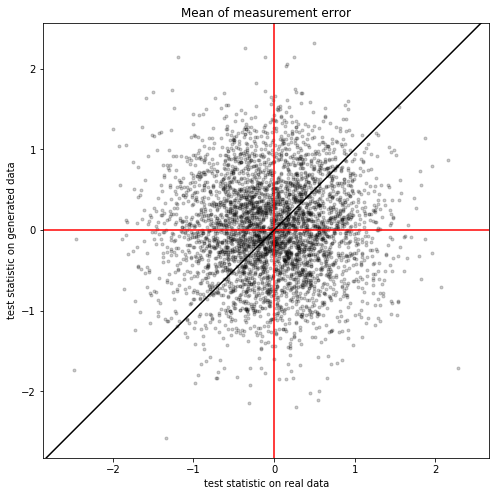

Mean of measurement error p-value: 0.51375


In [5]:
# Test 1: The measurement error should have mean 0.

# The name of the test statistic.
name = 'Mean of measurement error'
# The test statistic for the real data.
real = np.mean(real_samples, axis=1)
# The test statistic for the generated data.
generated = np.mean(generated_samples, axis=1)
# The measurement error is a normal distribution with 0 mean.
expected_value = 0

def make_scatter_plot(name, real, generated, expected_value):
    plt.figure(figsize=(8, 8))
    plt.plot(real, generated, 'k.', alpha=0.2)
    plt.axis('equal')  # Force the axes to have square aspect ratio.
    plt.title(name)
    plt.xlabel('test statistic on real data')
    plt.ylabel('test statistic on generated data')
    # Draw red horizontal and vertical lines at the expected value of the test
    # statistic.
    if expected_value is not None:
        plt.axvline(expected_value, color='red')
        plt.axhline(expected_value, color='red')
    # Draw a 45 degree line. If the data follow the model distribution, we
    # expect half of the data to lie above and half to lie below this line.
    axes = plt.gca()
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    coords = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
    axes.plot(coords, coords, color='black')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    plt.show()

make_scatter_plot(name, real, generated, expected_value)

# Compute the p-value as the fraction of points that lie below the 45
# degree line in the plot.
p = np.mean(real < generated)
print(name, 'p-value:', p)

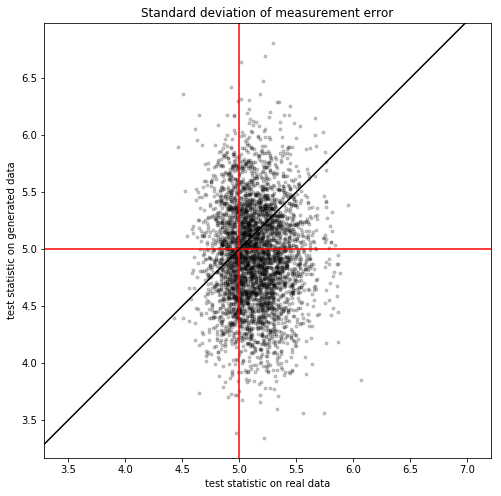

Standard deviation of measurement error p-value: 0.35175


In [6]:
# Test 2: The measurement error should have standard deviation sigma_y.

name = 'Standard deviation of measurement error'
real = np.std(real_samples, axis=1)
generated = np.std(generated_samples, axis=1)
expected_value = data['sigma_y']

make_scatter_plot(name, real, generated, expected_value)

p = np.mean(real < generated)
print(name, 'p-value:', p)

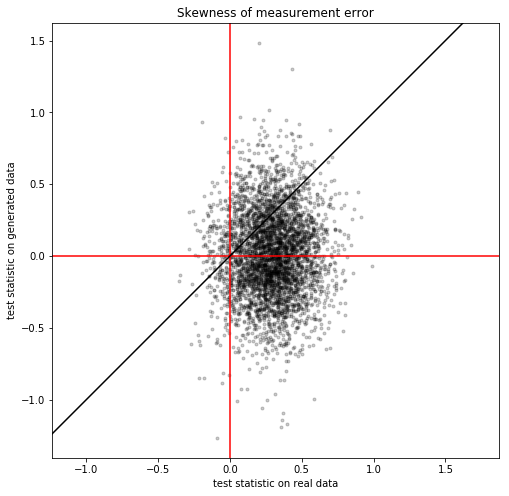

Skewness of measurement error p-value: 0.2145


In [7]:
# Test 3: The measurement error should be symmetric (have skewness 0)

name = 'Skewness of measurement error'
real = stats.skew(real_samples, axis=1)
generated = stats.skew(generated_samples, axis=1)
expected_value = 0

make_scatter_plot(name, real, generated, expected_value)

p = np.mean(real < generated)
print(name, 'p-value:', p)

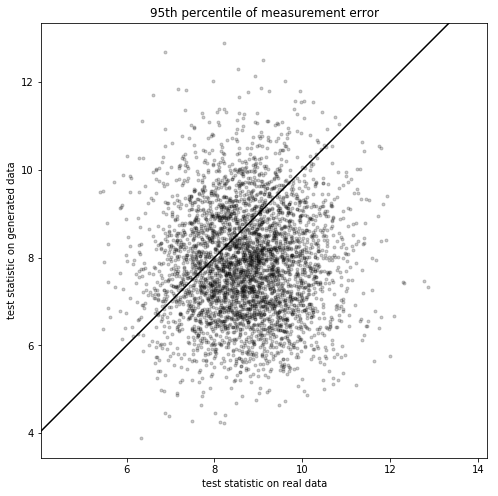

95th percentile of measurement error p-value: 0.297


In [8]:
# Test 4: 95th percentiles of the measurement error

name = '95th percentile of measurement error'
real = np.percentile(real_samples, 95, axis=1)
generated = np.percentile(generated_samples, 95, axis=1)
expected_value = None

make_scatter_plot(name, real, generated, expected_value)

p = np.mean(real < generated)
print(name, 'p-value:', p)

## Velocity distribution
According to the model, $v_{t+1}$ is normally distributed around $v_t$ with variance $\sigma_v^2$. As test statistics, we use the mean, standard deviation and skewness of the differences between consecutive velocities, $v_{t+1} - v_{t}$ with $t=0,1,\ldots,T-1$.

In this case we are not using the data as part of the comparison. We are looking at whether samples from the posterior over velocities fit our modeling assumptions.

In [9]:
generated_samples = samples['v'][:, 1:] - samples['v'][:, :-1]

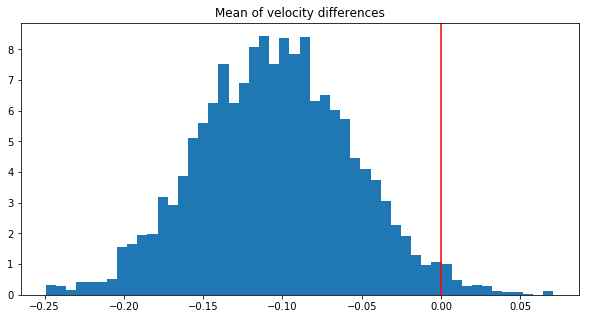

Mean of velocity differences p-value: 0.98225


In [10]:
# Test 1: The velocity differences should have mean 0.

# The name of the test statistic.
name = 'Mean of velocity differences'
# The test statistic for the generated data.
generated = np.mean(generated_samples, axis=1)
# The measurement error is a normal distribution with 0 mean.
expected_value = 0

def make_histogram(name, generated, expected_value):
    plt.figure(figsize=(10, 5))
    plt.hist(generated, bins=50, density=True)
    plt.title(name)
    # Draw red vertical line at the expected value of the test statistic.
    if expected_value is not None:
        plt.axvline(expected_value, color='red')
    plt.show()

make_histogram(name, generated, expected_value)

# Compute the p-value as the fraction of points that lie to the left of the
# expected value.
p = np.mean(generated < expected_value)
print(name, 'p-value:', p)

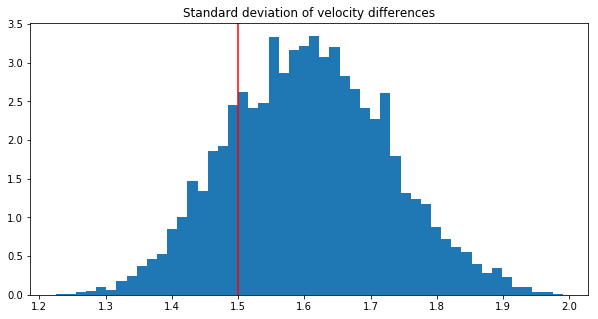

Standard deviation of velocity differences p-value: 0.19725


In [11]:
# Test 2: The velocity differences should have standard deviation sigma_v.

name = 'Standard deviation of velocity differences'
generated = np.std(generated_samples, axis=1)
expected_value = data['sigma_v']

make_histogram(name, generated, expected_value)

p = np.mean(generated < expected_value)
print(name, 'p-value:', p)

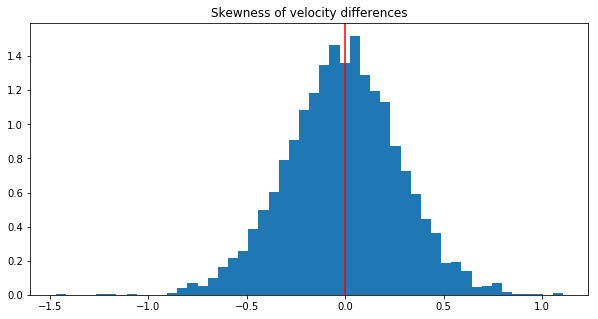

Skewness of velocity differences p-value: 0.5095


In [12]:
# Test 3: The velocity differences should have skewness 0.

name = 'Skewness of velocity differences'
generated = stats.skew(generated_samples, axis=1)
expected_value = 0

make_histogram(name, generated, expected_value)

p = np.mean(generated < expected_value)
print(name, 'p-value:', p)

## Position distribution
According to the model, $x_{t+1}$ is normally distributed around $x_t + v_t$ with variance $\sigma_x^2$. As test statistics, we use the mean, standard deviation and skewness of $x_{t+1} - (x_t + v_t)$ with $t=0,1,\ldots,T-1$.

In [13]:
generated_samples = samples['x'][:, 1:] - (samples['x'][:, :-1] + samples['v'][:, :-1])

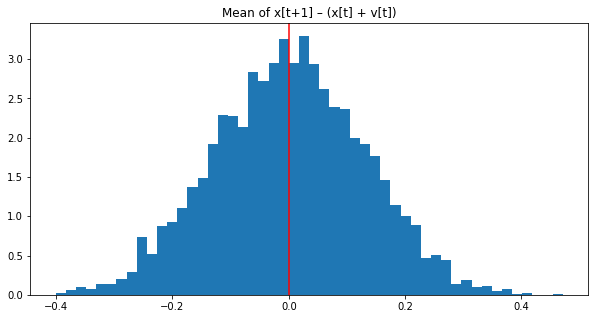

Mean of x[t+1] – (x[t] + v[t]) p-value: 0.4955


In [14]:
# Test 1: The differences should have mean 0.

name = 'Mean of x[t+1] – (x[t] + v[t])'
generated = np.mean(generated_samples, axis=1)
expected_value = 0

make_histogram(name, generated, expected_value)

p = np.mean(generated < expected_value)
print(name, 'p-value:', p)

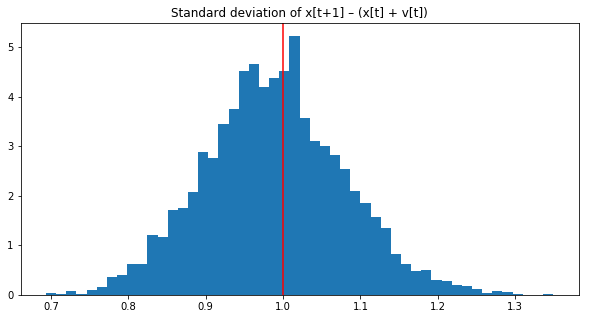

Standard deviation of x[t+1] – (x[t] + v[t]) p-value: 0.5615


In [15]:
# Test 2: The differences should have standard deviation sigma_x.

name = 'Standard deviation of x[t+1] – (x[t] + v[t])'
generated = np.std(generated_samples, axis=1)
expected_value = data['sigma_x']

make_histogram(name, generated, expected_value)

p = np.mean(generated < expected_value)
print(name, 'p-value:', p)

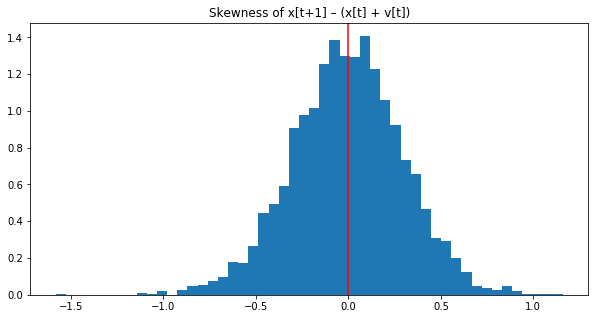

Skewness of x[t+1] – (x[t] + v[t]) p-value: 0.50375


In [16]:
# Test 3: The differences should have skewness 0.

name = 'Skewness of x[t+1] – (x[t] + v[t])'
generated = stats.skew(generated_samples, axis=1)
expected_value = 0

make_histogram(name, generated, expected_value)

p = np.mean(generated < expected_value)
print(name, 'p-value:', p)